In [3]:
import pandas as pd

# Load the datasets
train_file_path = 'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_train.tsv'
test_file_path = 'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_test.tsv'

# Load TSV files into DataFrames
train_data = pd.read_csv(train_file_path, sep='\t')
test_data = pd.read_csv(test_file_path, sep='\t')

# Display the first few rows of each dataset
train_data.head(), test_data.head()


(             event_name            tweet_id              image_id  \
 0  california_wildfires  917791291823591425  917791291823591425_0   
 1  california_wildfires  917791291823591425  917791291823591425_1   
 2  california_wildfires  917793137925459968  917793137925459968_0   
 3  california_wildfires  917793137925459968  917793137925459968_1   
 4  california_wildfires  917793137925459968  917793137925459968_2   
 
                                           tweet_text  \
 0  RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...   
 1  RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...   
 2  RT @KAKEnews: California wildfires destroy mor...   
 3  RT @KAKEnews: California wildfires destroy mor...   
 4  RT @KAKEnews: California wildfires destroy mor...   
 
                                                image            label  \
 0  data_image/california_wildfires/10_10_2017/917...      informative   
 1  data_image/california_wildfires/10_10_2017/917...  not_informative   
 2  data_ima

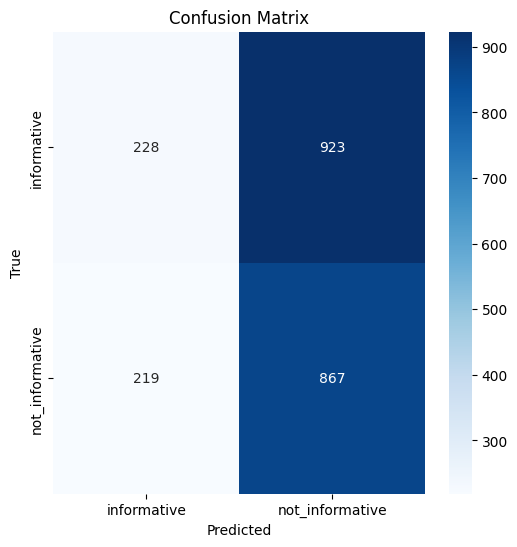

Few-Shot Learning Accuracy: 0.49


In [17]:
import random
import torch
import pandas as pd
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Select 20 random shots (support set) with 10 for each class
informative_shots = train_data[train_data['label_image'] == 'informative'].sample(10, random_state=42)
non_informative_shots = train_data[train_data['label_image'] == 'not_informative'].sample(10, random_state=42)
shots = pd.concat([informative_shots, non_informative_shots])

# Support images and labels
support_images = shots['image']
support_labels = shots['label_image']

# Encode support set (text embeddings)
text_inputs = processor(
    text=["informative", "not_informative"],
    return_tensors="pt",
    padding=True,  # Ensure equal length
    truncation=True  # Avoid exceeding max length
)
text_features = model.get_text_features(**text_inputs)

# Process images and predict
def predict_label(image_path, text_features):
    image = Image.open(image_path).convert("RGB")
    image_input = processor(images=image, return_tensors="pt")
    image_features = model.get_image_features(**image_input)

    # Normalize the image and text features
    image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)

    # Compute similarity between image and text features
    similarity = torch.matmul(image_features, text_features.T)
    return ["informative", "not_informative"][similarity.argmax().item()]

# Create the query set by selecting images from both classes
informative_query_images = test_data[test_data['label_image'] == 'informative']['image']
non_informative_query_images = test_data[test_data['label_image'] == 'not_informative']['image']

# Combine both informative and non-informative query images
query_images = pd.concat([informative_query_images, non_informative_query_images])

# Predict for query set
predictions = [predict_label(img, text_features) for img in query_images]

# Evaluate performance
test_data['predicted_label_image'] = predictions

# Compute the confusion matrix
cm = confusion_matrix(test_data['label_image'], test_data['predicted_label_image'], labels=["informative", "not_informative"])

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["informative", "not_informative"], yticklabels=["informative", "not_informative"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate accuracy
accuracy = (test_data['predicted_label_image'] == test_data['label_image']).mean()
print(f"Few-Shot Learning Accuracy: {accuracy:.2f}")
